In [1]:
import pandas as pd
import sys

# Simulate deletions of differing sizes

In [ ]:
'''
#!/bin/bash
#SBATCH --job-name=sim_indels
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --mem=10000
#SBATCH --time=0-80:00:00
#SBATCH --mail-type=END
#SBATCH --mail-user=ejt89@psu.edu
#SBATCH --chdir=/nfs/brubeck.bx.psu.edu/scratch4/edmundo/duplexSeq/reviews_gr
#SBATCH --output=/nfs/brubeck.bx.psu.edu/scratch4/edmundo/duplexSeq/reviews_gr/log/ejt89-meanR%j.out
#SBATCH --error=/nfs/brubeck.bx.psu.edu/scratch4/edmundo/duplexSeq/reviews_gr/log/ejt89-meanR%j.err

echo "Job started"; date "+%Y-%m-%d.%H:%M:%S"

DEL_SIZE=$1
ITERATIONS=10000

for i in `seq 1 ${ITERATIONS}`; do
 bash 1_run.sh $DEL_SIZE
 bash 2_call_vars.sh $DEL_SIZE
 cat del${DEL_SIZE}.mouse.chrM.vcf | paste <(echo $i) - >> TEMP${DEL_SIZE}.txt
done

mv TEMP${DEL_SIZE}.txt sim_del${DEL_SIZE}.txt

echo "Iterations that detected the deletion:"
python parse_simulations.py sim_del${DEL_SIZE}.txt | tail -n+5 | less | cut -f1 | awk '{OFS="\t"}{$1=$1; print}' | grep '\-d' | cut -f1 | uniq | wc -l
echo "Number of iterations:"
tail -n1 sim_del${DEL_SIZE}.txt | cut -f1

# # Coordinates of each iteration.
# cat log/ejt89-meanR_______.out | tail -n+3 | cut -f5 -d' ' | paste <(seq 1 10000) - > coords_del${DEL_SIZE}.txt
'''

# Parse simulation results

In [2]:
# This script parses a specific VCF-like output format where
# the iteration number only appears on the first line of each block of results.

import re
import sys

def get_column_safe(columns, index, default='.'):
    """
    Safely retrieves an element from a list by index.
    Returns a default value if the index is out of bounds or the value is empty.
    """
    try:
        value = columns[index].strip()
        return value if value else default
    except IndexError:
        return default

def parse_vcf_output(text_output):
    """
    Parses a multi-file, VCF-like output and extracts iteration numbers
    and variant information.

    Args:
        text_output (str): The raw text output containing multiple files.

    Returns:
        list: A list of dictionaries, where each dictionary represents
              a single variant record with its corresponding iteration.
    """
    # Split the entire text by the file markers (e.g., "==> TEMP100.txt <==\n")
    # This regex looks for lines that start with "==>" and end with "<==".
    file_sections = re.split(r'==>.*<==', text_output)
    
    parsed_records = []
    
    for section in file_sections:
        # Skip empty sections that might result from the split
        if not section.strip():
            continue
        
        lines = section.strip().split('\n')
        
        current_iteration = None
        
        for line in lines:
            # Skip empty lines
            if not line.strip():
                continue
            
            # Use regex to check for a line that starts with a number
            match = re.match(r'^\s*(\d+)\s+(.+)', line)
            
            if match:
                # This is the start of a new iteration block
                current_iteration = match.group(1).strip()
                vcf_data = match.group(2).strip()
            else:
                # This is a continuation line, use the last seen iteration
                vcf_data = line.strip()
            
            # Split the VCF-like data by tabs or multiple spaces
            # Use a regex that splits on one or more spaces
            columns = re.split(r'\t', vcf_data.strip())
            
            # The columns are not always consistent, so we'll grab the first 3 or 4
            # as the VCF-specific fields (CHROM, POS, ID, REF, ALT)
            if len(columns) >= 5:
                record = {
                    'iteration': current_iteration,
                    'CHROM': get_column_safe(columns, 0),
                    'POS': get_column_safe(columns, 1),
                    'REF': get_column_safe(columns, 3),
                    'ALT': get_column_safe(columns, 4),
                    'INFO': get_column_safe(columns, 7),
                    'FORMAT': get_column_safe(columns, 8),
                    'PILEUP': get_column_safe(columns, 9),
                    'raw_line': line.strip()
                }
                parsed_records.append(record)

    return parsed_records

def read_file(file_path):
    """Reads a file and returns its content as a single string."""
    try:
        with open(file_path, 'r') as file:
            return file.read()
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        sys.exit(1)

## Process VCF output

In [3]:
def process_vcf_output(del_size, file_dir="."):
    """
    Processes a VCF-like output file based on the given deletion size.

    Args:
        del_size (int): The deletion size to use for constructing file paths.

    Returns:
        None
    """
    input_file_path = f"{file_dir}/sim_del{del_size}.txt"
    output_file_path = f"{file_dir}/parsed_sim_del{del_size}.txt"
    
    # Read the content of the file
    file_content = read_file(input_file_path)

    # Parse the file content
    parsed_data = parse_vcf_output(file_content)

    # Write the parsed data to a file
    with open(output_file_path, "w") as output_file:
        output_file.write("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\n".format(
            "iteration", "CHROM", "POS", "REF", "ALT", "INFO", "FORMAT", "PILEUP"))
        
        for record in parsed_data:
            try:
                output_file.write("{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\t{:}\n".format(
                    record['iteration'],
                    record['CHROM'],
                    record['POS'],
                    record['REF'],
                    record['ALT'],
                    record['INFO'],
                    record['FORMAT'],
                    record['PILEUP']
                ))
            except KeyError as e:
                output_file.write(f"Skipping malformed record: {record}\n")
    
    # print(f"Parsed data has been written to '{output_file_path}'.")


# Plot results

Rate of 20-bp deletion detection:  1.0


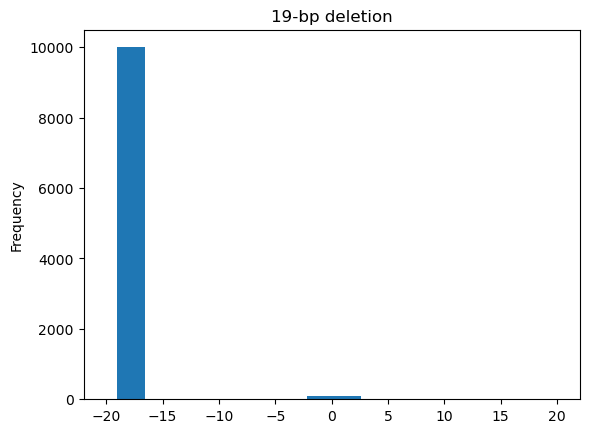

In [4]:
# del_size = 100

def run(del_size, file_dir="."):
    # Parse simulation results.
    process_vcf_output(del_size)
    df = pd.read_table( f"{file_dir}/parsed_sim_del{del_size}.txt", sep='\t' )

    try:
        # Coordinates of simulated deletion.
        df_coords = pd.read_table( f"{file_dir}/coords_del{del_size}.txt", sep='\t', names=['iteration','coords'] )
        df = pd.merge( df, df_coords )
    except:
        pass

    # Mutations types and length.
    df['ML'] = df.ALT.str.split(',').str[0].str.len() - df.REF.str.split(',').str[0].str.len()
    df['MT'] = df['ML'].apply(lambda x: 'subst' if x == 0 else 'indel')
    df['ML'].value_counts(sort=False)
    return df


def rate(del_size):
    df = run(del_size)
    times_detected = df[df['ML'] == -del_size+1].shape[0]

    # Calculate the rate of iterations with an indel
    indel_rates = times_detected / df['iteration'].max()
    print(f"Rate of {del_size}-bp deletion detection: ",indel_rates)
    return str(indel_rates)

def plot_lengths(del_size):
    df = run(del_size)
    # Plot.
    df[df['MT']=='indel']['ML'].plot(kind='hist', x='ML', title=f"{del_size-1}-bp deletion", 
                                     xlim=[-del_size*1.1,del_size*1.1], bins=10)


del_size = 20
run(del_size)
rate(del_size)
plot_lengths(del_size)

Rate of 100-bp deletion detection:  0.9976


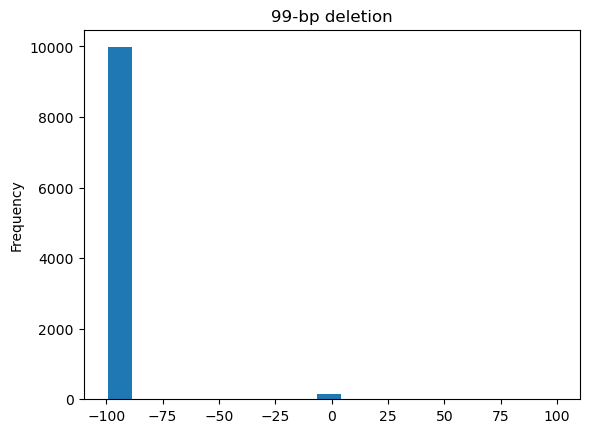

In [5]:
del_size = 100
run(del_size)
rate(del_size)
plot_lengths(del_size)

Rate of 150-bp deletion detection:  0.0


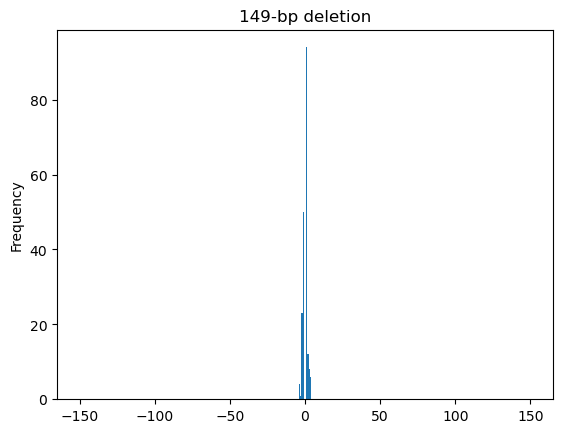

In [6]:
del_size = 150
run(del_size)
rate(del_size)
plot_lengths(del_size)

Rate of 200-bp deletion detection:  0.0


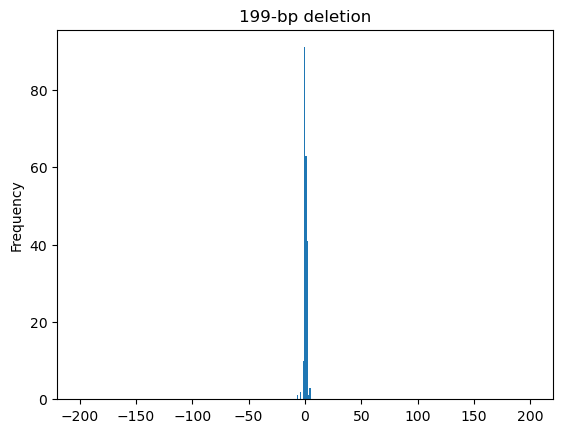

In [7]:
del_size = 200
run(del_size)
rate(del_size)
plot_lengths(del_size)

Rate of 250-bp deletion detection:  0.0


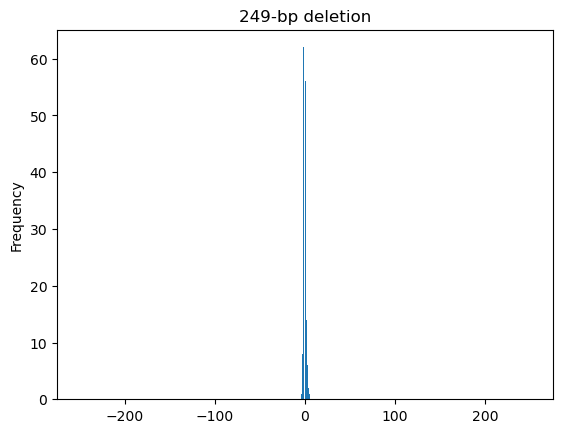

In [8]:
del_size = 250
run(del_size)
rate(del_size)
plot_lengths(del_size)

# Plot compiled results

Rate of 20-bp deletion detection:  1.0
Rate of 50-bp deletion detection:  1.0
Rate of 75-bp deletion detection:  0.9997
Rate of 100-bp deletion detection:  0.9976
Rate of 125-bp deletion detection:  0.0
Rate of 150-bp deletion detection:  0.0
Rate of 200-bp deletion detection:  0.0
Rate of 250-bp deletion detection:  0.0


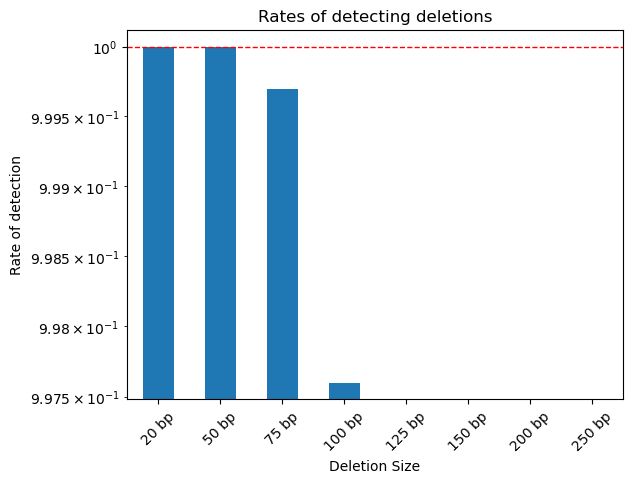

In [9]:
import matplotlib.pyplot as plt

rates = {'20 bp': float(rate(20)), 
         '50 bp': float(rate(50)),
         '75 bp': float(rate(75)),
         '100 bp': float(rate(100)), 
         '125 bp': float(rate(125)),
         '150 bp': float(rate(150)), 
         '200 bp': float(rate(200)), 
         '250 bp': float(rate(250))}

ax = pd.DataFrame({'Rate': rates.values()}, index=rates.keys()).plot(
    kind='bar', title='Rates of detecting deletions', 
        logy=True)
ax.set_xlabel("Deletion Size")
ax.set_ylabel("Rate of detection")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.axhline(y=1, color='red', linestyle='--', linewidth=1)
ax.legend().remove()

In [ ]:
# Table S1 of simulation results

In [12]:
# Create a summary table of detection rates for all tested deletion sizes
deletion_sizes = [20, 50, 75, 100, 125, 150, 200, 250]
results = []
read_size = 250

for size in deletion_sizes:
	detection_rate = float(rate(size))
	results.append({'Read Size (bp)': read_size, 'Deletion Size (bp)': size, 'Detection Rate': detection_rate})

results_df = pd.DataFrame(results)
display(results_df)

Rate of 20-bp deletion detection:  1.0
Rate of 50-bp deletion detection:  1.0
Rate of 75-bp deletion detection:  0.9997
Rate of 100-bp deletion detection:  0.9976
Rate of 125-bp deletion detection:  0.0
Rate of 150-bp deletion detection:  0.0
Rate of 200-bp deletion detection:  0.0
Rate of 250-bp deletion detection:  0.0


,Read Size (bp),Deletion Size (bp),Detection Rate
0,250,20,1.0000
1,250,50,1.0000
2,250,75,0.9997
3,250,100,0.9976
4,250,125,0.0000
5,250,150,0.0000
6,250,200,0.0000
7,250,250,0.0000
